In [50]:
import numpy as np
import pandas as pd
import seaborn as sb
from node import Node
from forest import Forest
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.datasets import make_moons, make_circles, make_classification
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
import sys
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# utility functions

def output_to_csv(result_list, filename):
    # writes result to .csv file
    df = pd.DataFrame({'id':range(len(result_list)),'label':result_list})
    df['label'] = df['label'].apply(int)
    df.to_csv(filename, column=['id','label'],index=False)
    
def encode_features(df):
    # Encodes features with numbers
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

In [12]:
# input data
df_train = pd.read_csv('kaggle_data/adult.data')
df_test = pd.read_csv("kaggle_data/adult.val")
# encode features
train_encoded, encoders = encode_features(df_train)
test_encoded, encoders = encode_features(df_test)
# create train and test sets
X_train = train_encoded[train_encoded.columns[:-1]].values
Y_train = train_encoded[train_encoded.columns[-1]].values
X_test = test_encoded.values

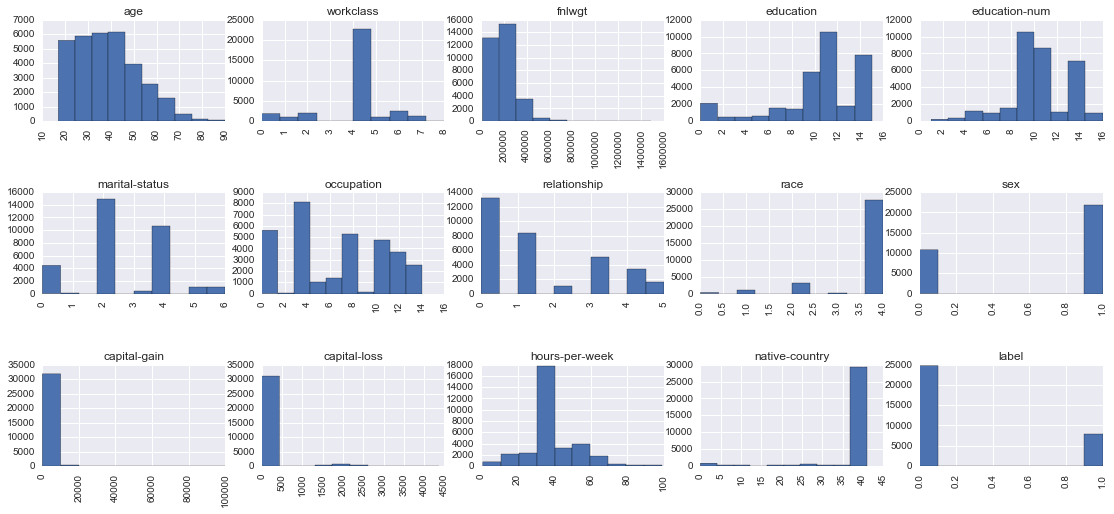

In [6]:
# plot all features in train set
fig = plt.figure(figsize=(19,8))
cols = 5
rows = ceil(float(train_encoded.shape[1]) / cols)
for i, column in enumerate(train_encoded.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    train_encoded[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)
plt.show()

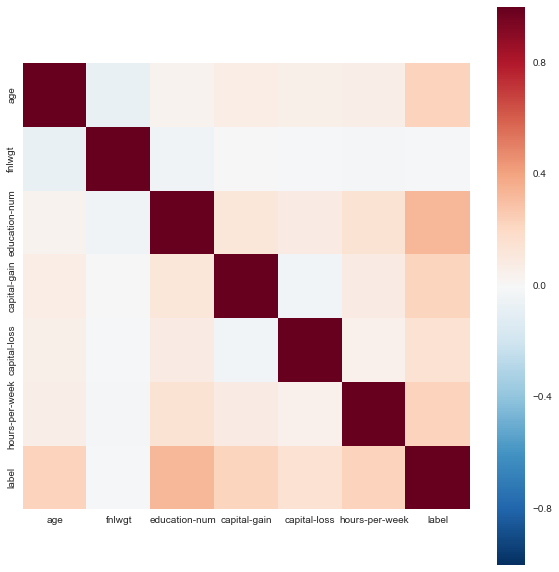

In [8]:
# Visualize numerical features  
numerical_features = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week','label']
plt.subplots(figsize=(10,10))
sb.heatmap(train_encoded[numerical_features].corr(), square=True)
plt.show()

## Decision tree (CART)
Реализация решающего дерева находится в `node.py`. Реализованы критерий Джини, критерий Twoing и энтропийный критерий (см. criteria.py). 

Про критерии: Джини и Twoing всегда дают почти одинаковый f1_score, энтропийный критерий иногда улучшает score.

In [22]:
# CART with max_depth=16, max_leaf_size=100 and gini criterion
cart = Node(16, 100, criterion='gini')
cart.fit(X_train[1000:], Y_train[1000:])  # fit returns number of nodes in the tree

759

In [23]:
%time y_pred = cart.predict(X_train[:1000])

CPU times: user 11.8 ms, sys: 5.42 ms, total: 17.3 ms
Wall time: 13.2 ms


In [25]:
# line only used for prediction output
# output_to_csv(y_pred.reshape(len(X_test),), "output.csv")

In [24]:
f1_score(Y_train[:1000], y_pred)


0.66508313539192399

## Tree visualisation
Для визуализации используется рекурсивный метод description, генерирующий описание дерева. В данном случае это не критично, поскольку высоты деревьев всегда небольшие - иначе оно переобучится.

Картинку лучше смотреть отдельно (сгенерировать с -Gdpi=1000)

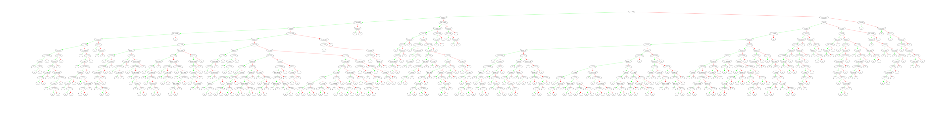

In [25]:
# Create a picture of your tree, using GraphViz
value = cart.description()
open('tree.dot', 'w').write(value)
!dot -Tpng -Gdpi=300 -Gsize=9,15 tree.dot -o tree.png
plt.figure(figsize=(16,9))
plt.axis('off')
img = mpimg.imread('tree.png')
plt.imshow(img)
plt.show()

## Tree comparison visualisation

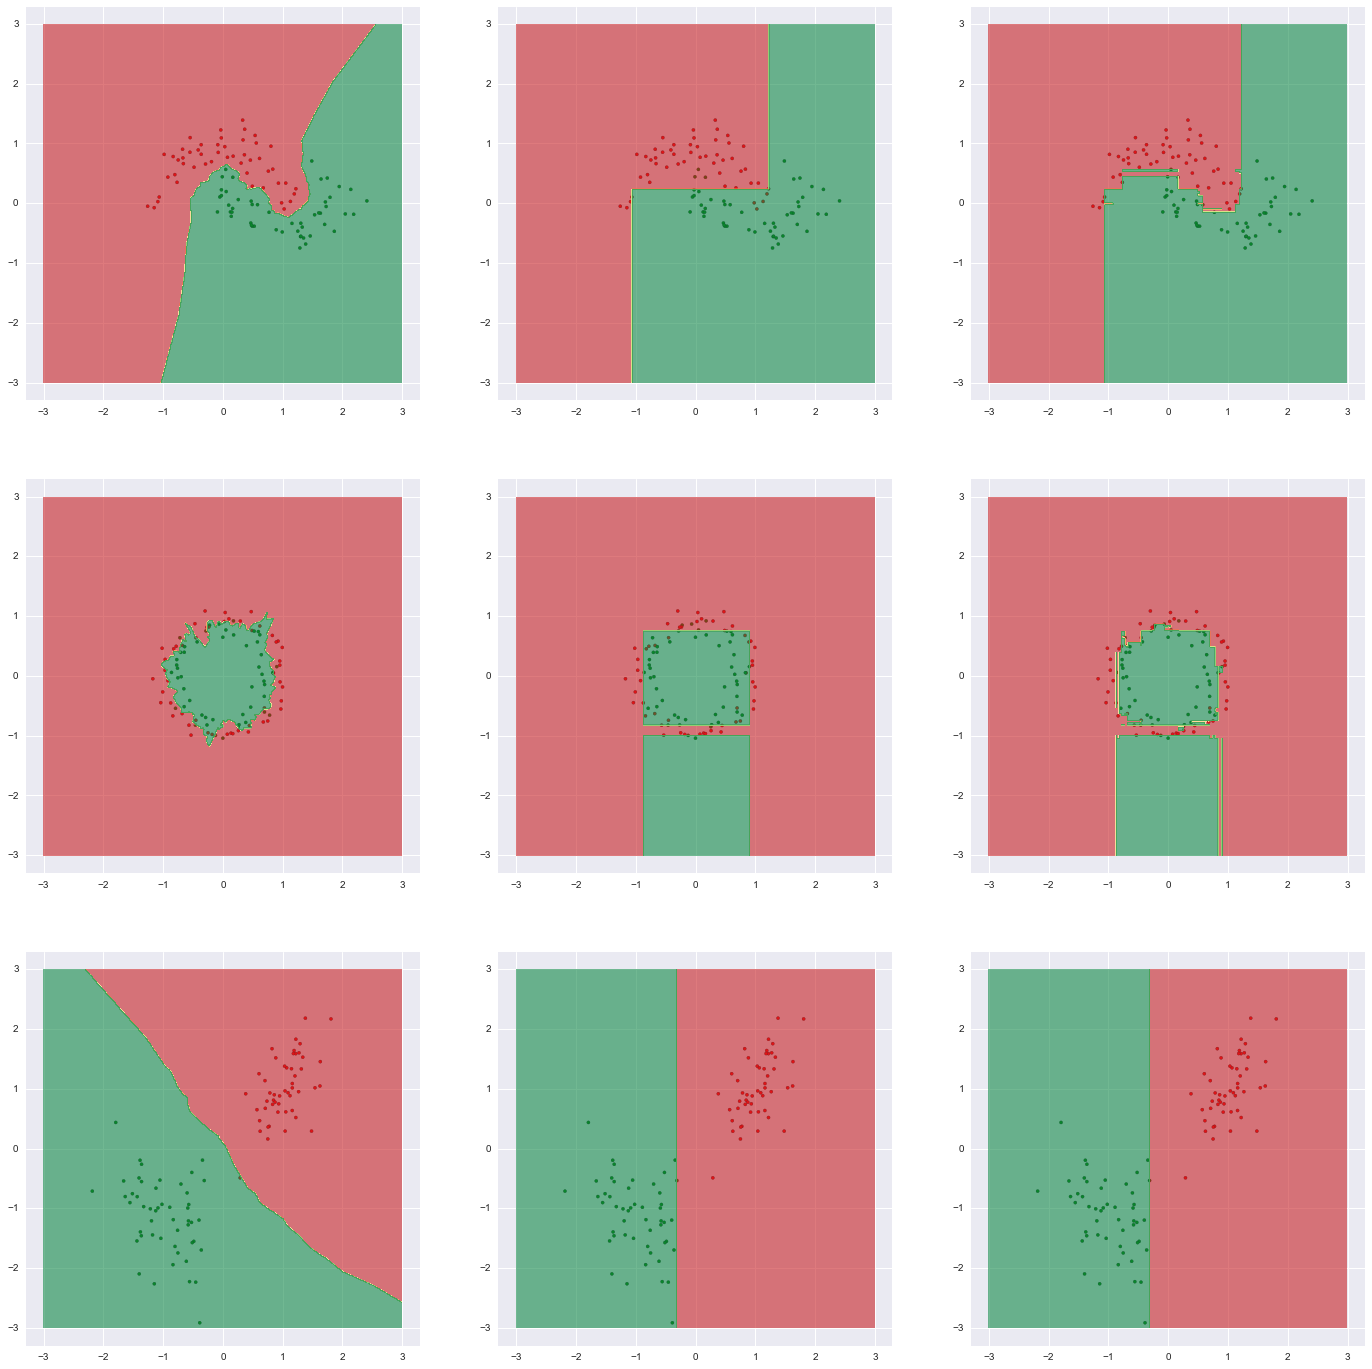

In [29]:
moons = make_moons(noise=0.2)
circles = make_circles(noise=0.1)
linear = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=8, n_clusters_per_class=1)
datasets = [moons, circles, linear]
knn = KNeighborsClassifier()
cart = Node(5, 1, criterion='gini')
forest = Forest(50)
classifiers = [knn, cart, forest]
color_map = ListedColormap(['#FF0000','#008000'])
step = 0.01
xx, yy = np.meshgrid(np.arange(-3, 3, step),
                     np.arange(-3, 3, step))
test = np.c_[xx.ravel(), yy.ravel()]
plot_number = 0
plt.figure(figsize=(24,24))
for dataset in datasets:
    for classifier in classifiers:
        X,y = dataset
        classifier.fit(X,y)
        clf_pred = np.array(classifier.predict(test))
        clf_pred = clf_pred.reshape(xx.shape)
        plot_number+=1
        plot = plt.subplot(3,3,plot_number)
        plot.scatter(X[:,0], X[:,1],c=y, cmap=color_map,s=10)
        plot.contourf(xx,yy,clf_pred,alpha=.6,cmap=plt.cm.RdYlGn)


Из графиков выше видно, что KNN более устойчив к выбросам и шуму, чем решающее дерево. Однако на выборках, где объекты разных классов кластеризованы, оба алгоритма справляются одинаково.

Также видно, что при большом количестве деревьев random forest приближается по качеству к KNN на первых двух выборках - большое количество деревьев повышает устойчивость к шуму.

Также поскольку мы говорим о классификации точек плоскости, то есть таких объектов, на которых можно ввести метрику, то KNN больше подходит для этой выборки, чем решающее дерево. Ведь решающее дерево будет и отделять классы ломаной, параллельной осям координат (решающими пнями), причем, поскольку оно малой высоты, то можно случайно захватывать большое количество "неправильных" точек. Напротив, ести увеличить высоту, то можно переобучиться под конкретные точки.

## Tree bagging
The training algorithm for random forests applies the general technique of bootstrap aggregating, or bagging, to tree learners. Given a training set $X=x_1,...,x_n$ with responses $Y = y_1, ..., y_n$, bagging repeatedly ($ B $ times) selects a random sample with replacement of the training set and fits trees to these samples.
After training, predictions for unseen samples $ x' $ can be made by averaging the predictions from all the individual regression trees on $x'$:

$$ \hat{f} = \frac{1}{B} \sum_{b=1}^B \hat{f}_b (x') $$

or by taking the majority vote in the case of decision trees.

This bootstrapping procedure leads to better model performance because it decreases the variance of the model, without increasing the bias. This means that while the predictions of a single tree are highly sensitive to noise in its training set, the average of many trees is not, as long as the trees are not correlated. Simply training many trees on a single training set would give strongly correlated trees (or even the same tree many times, if the training algorithm is deterministic); bootstrap sampling is a way of de-correlating the trees by showing them different training sets.

Случайный лес и функция `bagging` реализованы в `forest.py`.

In [31]:
forest = Forest(10)
forest.fit(X_train[1000:], Y_train[1000:])
%time y_pred = forest.predict(X_train[:1000])

CPU times: user 77.5 ms, sys: 726 µs, total: 78.2 ms
Wall time: 78.8 ms


In [250]:
# line only for result output
# output_to_csv(y_pred.reshape((len(X_test),)), "output.csv")

In [47]:
f1_score(Y_train[:1000], y_pred.reshape(1000,))

0.6469135802469136

## F1 score and Cross Validation Algorithm implementation

In [44]:
# F1 score

def f1(y_true, y_predict):
    true_positive_indices = np.logical_and(y_predict == 1, y_true == 1)
    true_positive = float(len(y_predict[true_positive_indices]))
    false_positive_indices = np.logical_and(y_predict == 1, y_true == 0)
    false_positive = float(len(y_predict[false_positive_indices]))
    relevant = float(len(y_true[y_true == 1]))
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / relevant
    score = 2 * precision * recall / (precision + recall)
    return score

In [33]:
# Cross validation

def cross_validation(X, y, score, max_depth, leaf_node_size, criterion, num_trees=10, cv_fold=2):
    # performing random permutation on data
    perm = np.random.permutation(X.shape[0])
    X = X[perm]
    y = y[perm]
    # dividing into chunks
    chunks = []
    y_chunks = []
    start = 0
    chunk_size = X.shape[0] / cv_fold
    end = chunk_size
    while end < X.shape[0]:
        chunks.append(X[start:end])
        y_chunks.append(y[start:end])
        start = end
        end += chunk_size
        
    # calculating f1_score for each chunk
    scores = []
    for i in range(len(chunks)):
        # tree cross-validation
        
        # cart = Node(1, max_depth, leaf_node_size, criterion)
        # cart.fit(np.concatenate(chunks[:i]+chunks[i+1:],axis=0),
        #          np.concatenate(y_chunks[:i]+y_chunks[i+1:],axis=0))
        # y_pred = cart.predict(chunks[i])
        
        # forest cross-validation
        
        forest = Forest(num_trees, max_depth, leaf_node_size, criterion)
        forest.fit(np.concatenate(chunks[:i]+chunks[i+1:],axis=0),
                   np.concatenate(y_chunks[:i]+y_chunks[i+1:],axis=0))
        y_pred = forest.predict(chunks[i])
        y_pred = y_pred.reshape((len(chunks[i]),))
        scores.append(score(y_chunks[i], y_pred))
    return np.mean(scores)

In [48]:
# You can try to vary tree or forest parameters, or to do something more clever with forest itself.
criteria = ['gini', 'twoing', 'entropy']
depths = [2**num for num in xrange(4, 8)]
leaf_sizes = [2**num for num in xrange(2, 8)]
out_file = open("cross_val_tree.txt", 'w')
for max_depth in depths:
    for criterion in criteria:
        for num_trees in xrange(10, 35, 5):
            score = cross_validation(X_train, Y_train, f1_score, max_depth, 128, criterion, num_trees)
            result = "{} {} {} {}: {}".format(max_depth, 128, criterion, num_trees, score)
            print result
            sys.stdout.flush()
            out_file.write(result + '\n')
out_file.close()

Для подбора параметров алгоритма (критерий, высота, количество деревьев, размер листа) использовался алгоритм кросс-валидации. 

Сначала он был запущен для одного дерева, где перебиралась высота и размер листа по степеням 2 (чтобы найти нужный промежуток значений). Затем, на найденном промежутке был сделан более подробный перебор. 

Для `random forest` был сделан аналогичный перебор, но по высоте и количеству деревьев.

Что получилось в итоге:

Результаты кросс-валидации лежат в `cross_val_tree.txt`, `cross_val_forest.txt` и `cross_val_forest_2.txt`. Из них видно, что лучший score для одного дерева достигался при высоте 16, и размере листа 128.

Также, можно сделать вывод, что критерии Джини и Twoing дают одинаковые результаты. 

Еще, при одной и той же высоте дерева изменение размера листа от 4 до 128 не приводит к изменению score. Понятно, что если увеличивать размер листа сильнее, то изменения будут и скорее будет ухудшение, но для таких значений значительных отличий не было.

Для леса перебирались не очень большие (до 30 включительно) количества деревьев, чтобы сократить время вычислений. Из данных видно, что при таких количествах деревьев роль в score играет скорее их высота. Поэтому для посылки на Kaggle было выбрано количество деревьев почти в 2 раза больше - 50 и небольшая высота - 16 с маленьким размером листа 4. Поскольку это обучалось достаточно долго, а дождаться 100 деревьев у меня не хватило терпения, окончательным вариантом стал random forest с 50 деревьями. Этот вариант набрал наибольший score на Kaggle.